In [ ]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

In [ ]:
# fmt: off
from numpy import random 

data1 = random.poisson(lam = 1, size = 50)
data2 = random.poisson(lam = 100, size = 50)
data3 = random.poisson(lam = 1, size = 50)
data4 = random.poisson(lam = 100,size = 50)

zircons_data = np.concatenate([data1,data2,data3,data4])
ages_nominal = np.arange(0, 200)

plt.plot(ages_nominal, zircons_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Ages");

In [4]:
#k=3 , n=200
#读取用来查的表switchPointList

switchPointList = []

import csv

f = open('3_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList.append(temp)
print(len(switchPointList))

1313400


In [5]:
print(switchPointList[0])

[1, 2, 3]


In [6]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at

@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:switchPoints[2]] = rates[2]
    rate[switchPoints[2]:] = rates[3]
    return rate

In [7]:
with pm.Model() as zircons_model:
    
    k = 3
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    

    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    
    index = pm.DiscreteUniform("index", lower = 0, upper = len(switchPointList))
    rates = pm.Exponential("rates",1.0,shape = k+1)
    rate = rate_(index, rates)
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rates]
>Metropolis: [index]


E:\anaconda\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


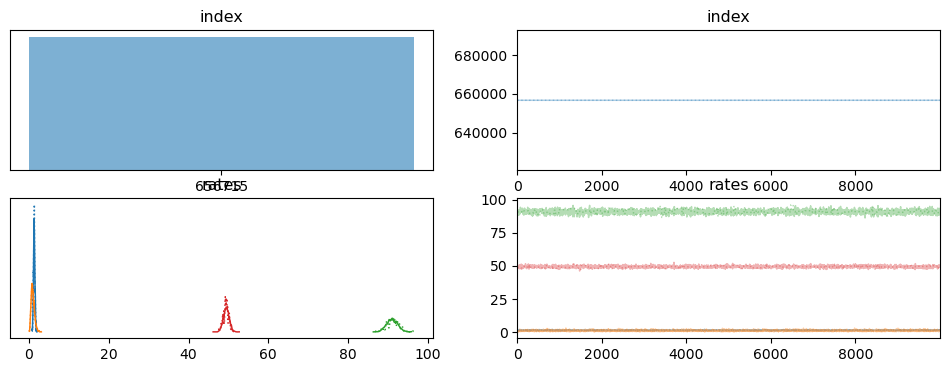

In [8]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([rates])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    #start = {"rates": (2.0 , 2.0 , 2.0)}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(tune = 10000, draws = 10000, step=[step1, step2],cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

In [9]:
az.summary(tr)

E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,656715.000,0.000,656715.000,656715.000,0.000,0.000,20000.0,20000.0,NaN
rates[0],1.326,0.181,1.002,1.671,0.003,0.002,2819.0,2677.0,1.00
rates[1],0.993,0.415,0.299,1.787,0.006,0.004,4418.0,4075.0,1.00
rates[2],91.113,1.449,88.487,93.728,0.065,0.046,494.0,510.0,1.02
rates[3],49.416,0.709,48.058,50.710,0.030,0.021,565.0,424.0,1.01


In [10]:
print(print(switchPointList[656715]))

[42, 47, 100]
None


In [ ]:
tr =pm.distributions.transforms

Order = tr.Ordered()

#Logodd = tr.LogOddsTransform()

#chain_tran = tr.Chain([Logodd, Order])

In [14]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 438 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],1.502,0.285,1.063,2.077,0.060,0.045,25.0,70.0,1.08
rates[1],48.503,10.186,34.168,61.491,7.109,5.990,2.0,11.0,2.90
rates[2],48.743,47.537,0.931,97.647,33.474,28.316,3.0,114.0,1.83
rates[3],50.058,46.552,1.691,98.046,32.779,27.727,3.0,12.0,2.11
switchpoints[0],19.020,8.130,4.462,34.363,5.081,4.151,3.0,11.0,1.94
switchpoints[1],124.731,24.910,99.188,149.999,17.541,14.839,3.0,41.0,1.84
switchpoints[2],174.558,25.043,149.138,200.000,17.636,14.919,3.0,61.0,1.88


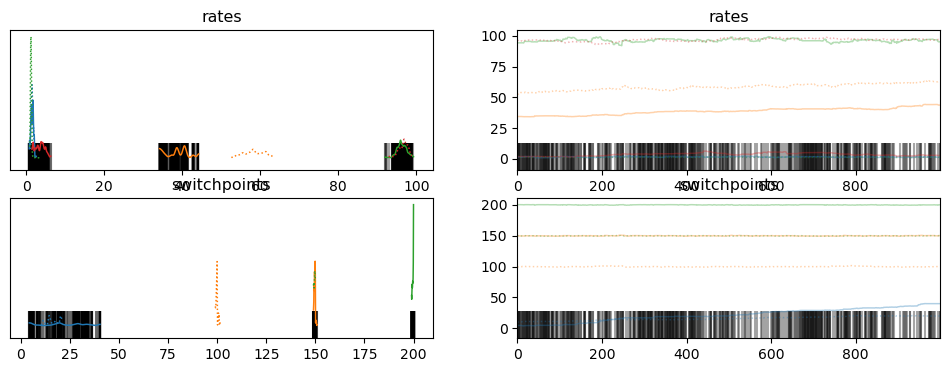

In [15]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [16]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr10000 = pm.sample(draws = 9000,  tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 1_000 tune and 9_000 draw iterations (2_000 + 18_000 draws total) took 2634 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],1.072,0.525,0.175,1.968,0.035,0.025,167.0,321.0,1.06
rates[1],17.042,16.657,0.388,34.261,11.771,9.974,3.0,37.0,1.86
rates[2],72.981,23.724,48.072,98.557,16.753,14.190,3.0,56.0,1.83
rates[3],51.095,47.168,3.412,99.736,33.337,28.248,2.0,12.0,2.70
switchpoints[0],1.980,1.218,0.143,3.733,0.844,0.709,2.0,14.0,2.84
switchpoints[1],99.476,50.053,49.032,149.945,35.376,29.976,3.0,40.0,1.85
switchpoints[2],174.510,24.971,149.111,199.961,17.648,14.954,3.0,63.0,1.83


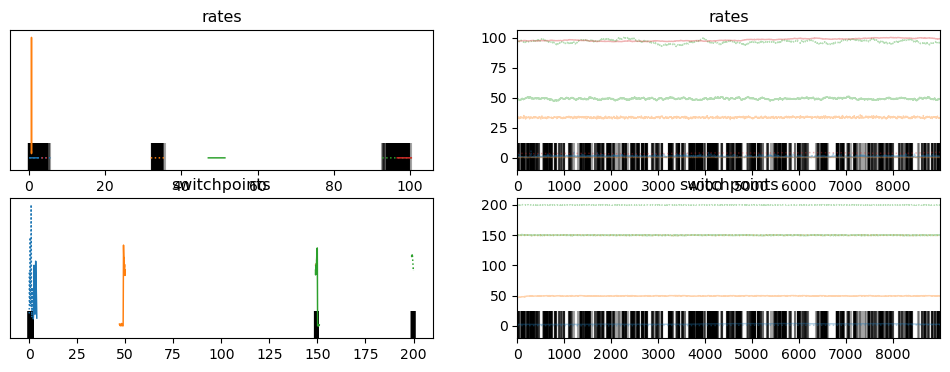

In [18]:
with model:
    az.plot_trace(tr10000)
    
pm.summary(tr10000)

In [19]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr30000 = pm.sample(draws = 20000,  tune = 10000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 8283 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],1.500,0.371,0.964,2.220,0.182,0.139,4.0,131.0,1.43
rates[1],48.666,47.653,0.643,97.866,33.684,28.543,3.0,37.0,1.84
rates[2],48.787,47.557,0.871,98.051,33.615,28.485,3.0,72.0,1.83
rates[3],73.070,23.625,48.120,98.511,16.688,14.136,3.0,58.0,1.83
switchpoints[0],32.381,17.331,12.102,50.000,12.184,10.358,3.0,26.0,1.98
switchpoints[1],74.480,24.969,49.000,99.821,17.651,14.958,3.0,49.0,1.83
switchpoints[2],124.514,25.017,99.121,149.999,17.686,14.987,3.0,48.0,1.83


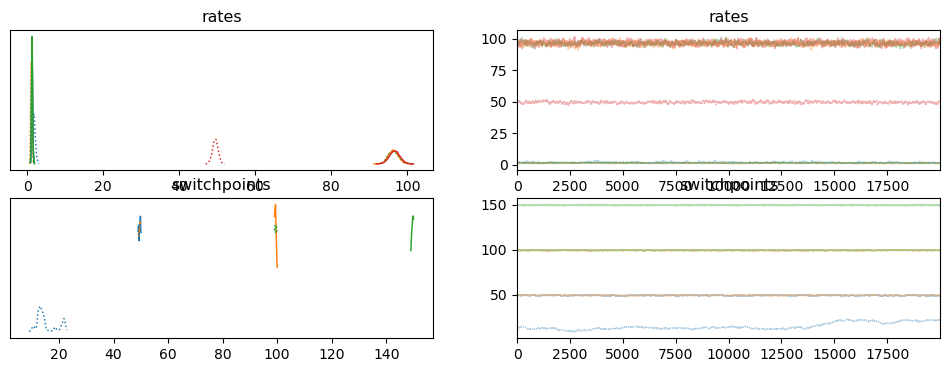

In [21]:
with model:
    az.plot_trace(tr30000)
    
pm.summary(tr30000)

In [25]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr30000_2 = pm.sample(draws = 10000,  tune = 20000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 7635 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],1.450,0.375,0.858,2.243,0.146,0.108,8.0,49.0,1.20
rates[1],25.212,24.055,0.798,50.146,16.999,14.403,3.0,59.0,1.84
rates[2],96.708,1.379,94.183,99.395,0.071,0.050,377.0,794.0,1.02
rates[3],25.213,24.252,0.001,50.239,17.133,14.514,3.0,65.0,1.83
switchpoints[0],29.306,20.239,6.888,50.000,14.298,12.119,3.0,11.0,2.12
switchpoints[1],99.500,49.998,49.036,149.915,35.339,29.945,3.0,54.0,1.83
switchpoints[2],149.497,50.010,99.007,199.889,35.347,29.952,3.0,47.0,1.83


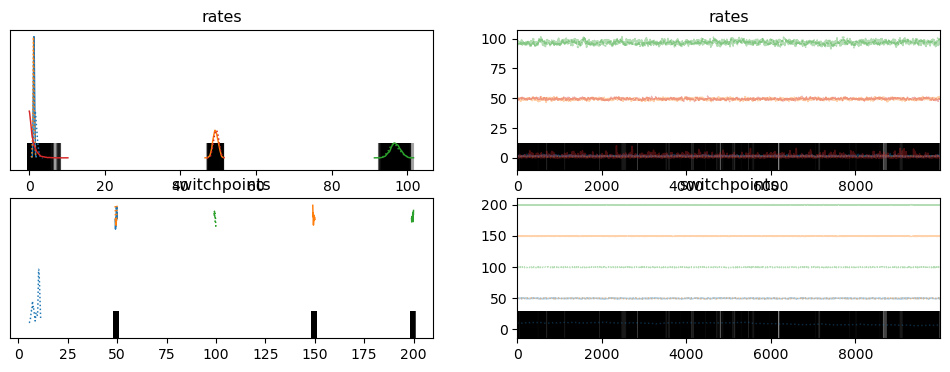

In [26]:
with model:
    az.plot_trace(tr30000_2)
    
pm.summary(tr30000_2)

In [22]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr30000 = pm.sample(draws = 40000,  tune = 10000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 10_000 tune and 40_000 draw iterations (20_000 + 80_000 draws total) took 12611 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],1.273,0.378,0.415,1.967,0.089,0.068,16.0,33.0,1.25
rates[1],47.618,46.582,0.669,97.522,32.881,27.845,3.0,14.0,1.99
rates[2],33.423,32.213,0.916,66.388,22.774,19.300,3.0,50.0,1.83
rates[3],48.926,47.935,0.000,98.517,33.883,28.711,3.0,78.0,1.83
switchpoints[0],28.935,20.272,1.094,50.000,14.016,11.939,3.0,49.0,2.02
switchpoints[1],74.557,25.056,49.092,100.000,17.714,15.012,3.0,33.0,1.83
switchpoints[2],174.500,25.005,149.123,199.996,17.679,14.982,3.0,46.0,1.83


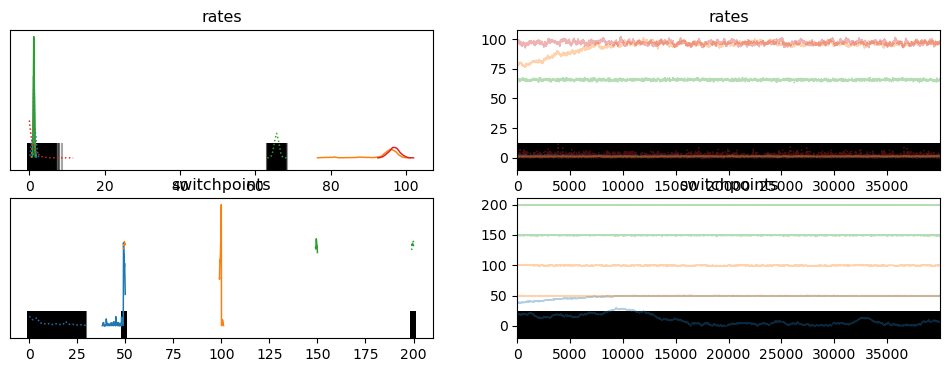

In [24]:
with model:
    az.plot_trace(tr30000)
    
pm.summary(tr30000)

In [27]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr30000_3 = pm.sample(draws = 5000,  tune = 25000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 25_000 tune and 5_000 draw iterations (50_000 + 10_000 draws total) took 7665 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],1.247,0.153,0.966,1.529,0.008,0.005,407.0,949.0,1.01
rates[1],72.804,23.531,48.102,98.288,16.612,14.069,3.0,82.0,1.88
rates[2],49.000,47.794,0.865,98.333,33.764,28.603,3.0,180.0,1.83
rates[3],48.739,47.852,0.011,98.189,33.801,28.633,3.0,124.0,1.83
switchpoints[0],49.494,0.295,49.037,49.981,0.091,0.066,13.0,162.0,1.15
switchpoints[1],124.505,24.979,99.140,149.998,17.648,14.951,3.0,84.0,1.83
switchpoints[2],174.481,25.034,149.001,199.874,17.687,14.984,3.0,56.0,1.83


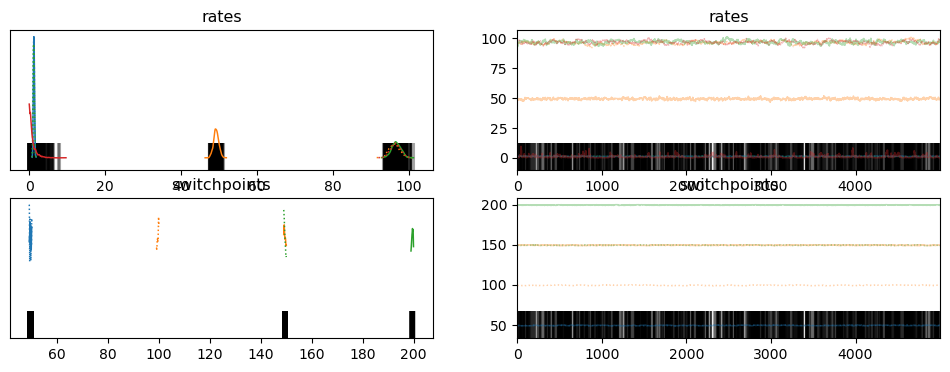

In [28]:
with model:
    az.plot_trace(tr30000_3)
    
pm.summary(tr30000_3)

In [ ]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = 200 , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr35000 = pm.sample(draws = 10000,  tune = 25000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr35000)
    
pm.summary(tr35000)